Проект e-commerce: вариант 1 Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

ФАЙЛ: olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)

customer_zip_code_prefix — почтовый индекс пользователя

customer_city — город доставки пользователя

customer_state — штат доставки пользователя

ФАЙЛ: olist_orders_dataset.csv — таблица заказов 
    
order_id — уникальный идентификатор заказа (номер чека)

customer_id — позаказный идентификатор пользователя

order_status — статус заказа

order_purchase_timestamp — время создания заказа

order_approved_at — время подтверждения оплаты заказа

order_delivered_carrier_date — время передачи заказа в логистическую службу

order_delivered_customer_date — время доставки заказа

order_estimated_delivery_date — обещанная дата доставки

ФАЙЛ: olist_order_items_dataset.csv — товарные позиции, входящие в заказы

order_id — уникальный идентификатор заказа (номер чека)

order_item_id — идентификатор товара внутри одного заказа

product_id — ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price — цена за единицу товара

freight_value — вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created — создан

approved — подтверждён

invoiced — выставлен счёт

processing — в процессе сборки заказа

shipped — отгружен со склада

delivered — доставлен пользователю

unavailable — недоступен

canceled — отменён

In [2]:
# required libraries
import pandas as pd
import numpy as np
from scipy import stats
import requests
from urllib.parse import urlencode
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [3]:
# import таблица с уникальными идентификаторами пользователей from Yandex.cloud
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
df_users=pd.read_csv(download_url)

In [4]:
df_users.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
df_users.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [6]:
df_users.info() # нет нулевых значений!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
# import таблица заказов from Yandex.cloud
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
df_orders=pd.read_csv(download_url, parse_dates=['order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'] )

In [8]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [131]:
df_orders.order_id.nunique()

99441

In [9]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
# import товарные позиции, входящие в заказы from Yandex.cloud
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
df_products=pd.read_csv(download_url, parse_dates=['shipping_limit_date'])

In [11]:
df_products.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)
Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Данные не идеальные, поскольку в них есть строчки, в которых статус delivered, 
а дата доставки (order_delivered_customer_date) отсутствует и также, наоборот, есть дата доставки, но статус не delivered. Кроме того, при статусе delivered
могут отсутствовать дата order_approved_at и т.д.
Эти строки удаляем, а расчёт числа пользователей с количеством покупок делаем без них. 

Итого: 
Покупками считаем только те строки, где есть как статус delivered и также заполнены другие критичные даты:
    
order_approved_at

order_delivered_carrier_date

order_delivered_customer_date

Кроме того, для решения объединяем данные по заказам с данными по клиентам, чтобы использовать уникальные id клиентов для расчётов.

Далее после необходимой фильтрации группируем по уникальным id клиентов и считаем количество заказов для каждого клиента, переименовываем колонку с количеством заказов, фильтруем по количеству заказов равному 1 и делаем окончательный расчёт количества клиентов, которые сделали только один заказ.

Answer: 90536.


Оставляем строки по которым есть все необходимые даты и статус delivered. По строкам, где нет какой-то информации необходимо дополнительное изучение отделу, ответственному за заполнение информации.

In [13]:
df_orders.merge(df_users, on='customer_id')\
         .query('order_status=="delivered"')\
         .loc[df_orders.order_delivered_customer_date.notnull()]\
         .loc[df_orders.order_approved_at.notnull()]\
         .loc[df_orders.order_delivered_carrier_date.notnull()]\
         .groupby(['customer_unique_id'],as_index=False)\
         .agg({'order_id':'count'})\
         .rename(columns={'order_id':'n_orders'})\
         .query('n_orders==1')\
         .count()

customer_unique_id    90536
n_orders              90536
dtype: int64

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

Предварительные рассуждения и постановка задачи:
Для начала определим, что значит "...в месяц в среднем не доставляется", поскольку,например, доставка может быть осуществлена в следующий месяц после месяца создания заказа. Как в этом случае считать была ли доставка или нет в конкретном месяце?
Например, возможно, доставка была задержана по каким-то причинам, что не хорошо и это должно быть отражено в требуемом показателе. 

Кроме того, поскольку у нас данные за ограниченный период времени, то, возможно, что некоторые заказы созданы в конце периода, по которому есть информация, а факт их доставки не отражён в существующих данных.

Также могут быть перекосы с датами заказов, когда большая часть заказов была размещена в конце месяца и тогда доставка по таким заказам осуществились только в следующем месяце, что повлияет на средние показатели в месяц. 

Поскольку у нас нет обратной связи с менеджером, чтобы уточнить постановку задачи, в частности, что делать с заказами, которые были размещена в конце месяца, но из-за логистических операций были доставлены в следующих месяцах, то УПРОЩАЕМ постановку задачи, предполагая, что ВСЕ ЗАКАЗЫ ДОЛЖНЫ БЫТЬ ДОСТАВЛЕНЫ В ТОТ ЖЕ МЕСЯЦ, КОГДА БЫЛ СДЕЛАН ЗАКАЗ!!! 

Тогда из дальнейшего расчёта удаляем все доставленные (статус - delivered) заказы с месяцем доставки  совпадающим с месяцем создания заказа. В этом случае причинами непоставки будут все остальные статусы и статус delivered для поставок в следующих месяцах после месяца создания заказа, который далее обозначим как delivered_after. 

Также, как в ответе на вопрос 1 удалим из расчётов все заказы со статусом delivered, у которых не выставлены даты по критическим событиям, поскольку отсутствует ключевая подтверждающая информация по якобы доставленным заказам:

order_approved_at

order_delivered_carrier_date

order_delivered_customer_date

В идеальном варианте решения необходимо согласовать KPI с руководством по каждой операции/статусу. Например, подробный анализ причин непоставок против SLAs (Service Level Agreements) по каждой операции, что включает целевое время на транспортировку в разные города на разные расстояния, время обработки заказа-сбора заказа в зависимости от объёма заказа и т.д. В этом случае, задача станет более определённой и потребует изменения подхода к анализу.

Оставляем для дальнейшего анализа все заказы, которые по статусу НЕ delivered и заказы со статусом delivered с месяцем доставки несовпадающим с месяцем доставки.

In [21]:
df_orders_not_delivered=df_orders.query('(order_status!="delivered") | \
                                        ((order_status=="delivered") & \
                                         (order_purchase_timestamp.dt.month!=order_delivered_customer_date.dt.month))')

Убираем заказы со статусом delivered, но с NaN/NaT по обязательным и не заполненным полям (см. комментарий выше):

order_delivered_customer_date

order_approved_at

order_delivered_carrier_date

In [22]:
remove_list=df_orders_not_delivered.query('order_status=="delivered"')\
         .loc[df_orders.order_delivered_customer_date.isnull()].index # список с индексами строк, которые надо удалить

In [23]:
remove_list

Int64Index([3002, 20618, 43834, 79263, 82868, 92643, 97647, 98038], dtype='int64')

In [24]:
df_orders_not_delivered.drop(remove_list,inplace=True, errors='ignore')

In [25]:
remove_list=df_orders_not_delivered.query('order_status=="delivered"')\
         .loc[df_orders.order_approved_at.isnull()].index # список с индексами строк, которые надо удалить

In [26]:
remove_list

Int64Index([ 5323, 16567, 19031, 22663, 23156, 38290, 39334, 48401, 61743,
            63052, 67697, 72407, 84999],
           dtype='int64')

In [27]:
df_orders_not_delivered.drop(remove_list,inplace=True, errors='ignore')

In [28]:
remove_list=df_orders_not_delivered.query('order_status=="delivered"')\
         .loc[df_orders.order_delivered_carrier_date.isnull()].index # список с индексами строк, которые надо удалить

In [29]:
remove_list

Int64Index([73222], dtype='int64')

In [30]:
df_orders_not_delivered.drop(remove_list,inplace=True, errors='ignore')

Необходимо ещё сделать одну "чистку": удалить строки, в которых есть ненулевая дата доставки, но сам статус "delivered" отсутствует.

In [31]:
remove_list=df_orders_not_delivered\
         .query('order_status!="delivered"')\
         .loc[df_orders.order_delivered_customer_date.notnull()].index

In [32]:
remove_list

Int64Index([2921, 8791, 58266, 59332, 92636, 94399], dtype='int64')

In [33]:
df_orders_not_delivered.drop(remove_list,inplace=True, errors='ignore')

                 "ЧИСТКА" И ВЫБОР НЕОБХОДИМЫХ СТРОК ЗАКОНЧЕН!!!

In [34]:
df_orders_not_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39370 entries, 1 to 99438
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       39370 non-null  object        
 1   customer_id                    39370 non-null  object        
 2   order_status                   39370 non-null  object        
 3   order_purchase_timestamp       39370 non-null  datetime64[ns]
 4   order_approved_at              39224 non-null  datetime64[ns]
 5   order_delivered_carrier_date   37589 non-null  datetime64[ns]
 6   order_delivered_customer_date  36413 non-null  datetime64[ns]
 7   order_estimated_delivery_date  39370 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 2.7+ MB


Заменим ещё название статуса delivered на delivered_after, что подразумевает, что доставка произошла не в месяц заказа по пока неизвестным причинам

In [41]:
df_orders_not_delivered.order_status=df_orders_not_delivered.order_status.str.replace('delivered','delivered_after')

C:\Users\grebe\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
df_orders_not_delivered.order_status # проверка ... всё работает

1        delivered_after
3        delivered_after
6               invoiced
8        delivered_after
9        delivered_after
              ...       
99431    delivered_after
99432    delivered_after
99434    delivered_after
99435    delivered_after
99438    delivered_after
Name: order_status, Length: 39370, dtype: object

In [43]:
df_orders_not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered_after,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered_after,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered_after,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered_after,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23


Проверим на то, что у нас в колонке order_id только уникальные значения, чтобы не делать группировки. Всё ОК.

In [44]:
df_orders_not_delivered[df_orders_not_delivered.order_id.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


Создаём столбец нужного формата, где есть номер месяца и год, и убираем ненужные для анализа данные

In [57]:
df_orders_not_delivered['month']=df_orders_not_delivered.order_purchase_timestamp.dt.month
df_orders_not_delivered['year']=df_orders_not_delivered.order_purchase_timestamp.dt.year

In [59]:
df_orders_not_delivered=df_orders_not_delivered.astype({'month':'str','year':'str'})

In [61]:
df_orders_not_delivered['M/Y']=df_orders_not_delivered.month+'/'+df_orders_not_delivered.year
df_orders_not_delivered['M/Y']

1         7/2018
3        11/2017
6         4/2017
8         1/2017
9         7/2017
          ...   
99431    10/2017
99432    12/2017
99434     1/2017
99435     2/2017
99438     8/2017
Name: M/Y, Length: 39370, dtype: object

In [62]:
df_orders_not_delivered.reset_index(drop=True, inplace=True)

In [63]:
df_orders_not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,year,M/Y
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered_after,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,7,2018,7/2018
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered_after,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,11,2017,11/2017
2,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,4,2017,4/2017
3,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered_after,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,1,2017,1/2017
4,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered_after,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,7,2017,7/2017


In [64]:
df_analysis=df_orders_not_delivered[['order_id', 'order_status','M/Y']]

In [65]:
df_analysis

,order_id,order_status,M/Y
0,53cdb2fc8bc7dce0b6741e2150273451,delivered_after,7/2018
1,949d5b44dbf5de918fe9c16f97b45f8a,delivered_after,11/2017
2,136cce7faa42fdb2cefd53fdc79a6098,invoiced,4/2017
3,76c6e866289321a7c93b82b54852dc33,delivered_after,1/2017
4,e69bfb5eb88e0ed6a785585b27e16dbf,delivered_after,7/2017
...,...,...,...
39365,b0f4af5c1b06e24fef510703bfe9f0a6,delivered_after,10/2017
39366,cfa78b997e329a5295b4ee6972c02979,delivered_after,12/2017
39367,aa04ef5214580b06b10e2a378300db44,delivered_after,1/2017
39368,880675dff2150932f1601e1c07eadeeb,delivered_after,2/2017


Для общего понимания ситуации нарисуем графики по месяцам и разным статусам. Ниже исключим доставленные заказы, которые доставлены не в месяц заказа. В целом, видно, что больше всего заказов находятся в пути. Также отметим, что часто заказ не был выполнен по причине отсутствие нужной продукции на складе (статус - unavailable). 
NB: Для дальнейших расчётов не принципиально, что 'M/Y' не является временным типом данных, поскольку смотрим в конечном итоге на среднее количество неотгруженных заказов в месяц, а по 'M/Y' уже данные отсортированы по месяцам.

<AxesSubplot:xlabel='M/Y', ylabel='count'>

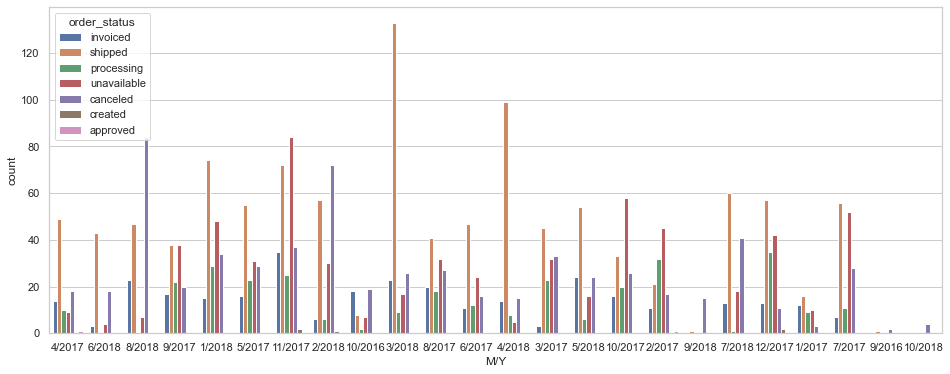

In [69]:
sns.countplot(x='M/Y', data=df_analysis.query('order_status!="delivered_after"'), hue='order_status')

Нарисуем график по месяцам со всеми статусами. Видно, что число заказов доставленных в месяц, не совпадающем с месяцем заказа, значительно больше чем недоставленных в месяц заказа по другим причинам.

<AxesSubplot:xlabel='M/Y', ylabel='count'>

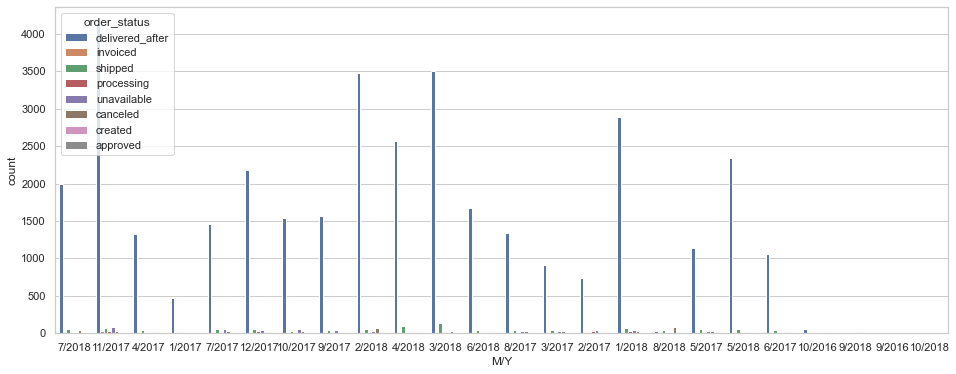

In [70]:
sns.countplot(x='M/Y', data=df_analysis, hue='order_status')

Финальный расчёт по причинам не доставки заказов в среднем в месяц:

In [97]:
df_analysis_final = df_analysis.groupby(['M/Y','order_status'],as_index=False)\
                               .count()\
                               .pivot(index='M/Y', columns='order_status', values='order_id')\
                               .fillna(0).mean().round(2)

In [98]:
df_analysis_final

order_status
approved              0.08
canceled             25.79
created               0.21
delivered_after    1517.21
invoiced             13.08
processing           12.54
shipped              46.12
unavailable          25.38
dtype: float64

Выводы:
1. В среднем за месяц, основное количество недоставленных в тот же месяц заказов находится в пути (delivered_after=1517.21 and shipped=46.12).
2. В среднем за месяц, примерно, по 25-26 заказов или отменены (canceled) или не отгружены по причине отсутствия заказанной продукции (unavailable).
3. Остальные заказы находятся в статусах подготовки к отгрузке.

И для дополнительно наглядности построим еще бар чарт по статусам в среднем в месяц без статуса delivered_after:

In [129]:
t=pd.DataFrame(df_analysis_final).reset_index().rename(columns={0:'avg_month'}).query('order_status!="delivered_after"')

<BarContainer object of 7 artists>

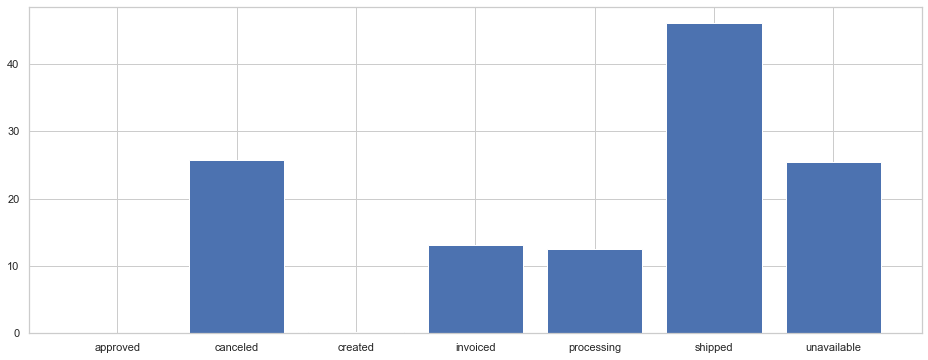

In [130]:
plt.bar(t.order_status, t.avg_month)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Предположение:

Будем считать, что в этом вопросе интересуемся в какой день недели товар чаще всего ЗАКАЗЫВАЕТСЯ, поскольку для поставщика, главное, обеспечить наличие товара на день заказа с последующим резервированием товара для отгрузки. Тогда анализ по дням недели будем проводить по order_purchase_timestamp.

In [132]:
df_3=df_orders.merge(df_products, on='order_id') # объединяем с данными по продуктам

In [133]:
df_3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [135]:
df_3['day_n']=df_3.order_purchase_timestamp.dt.weekday #добавим новый столбец с номером дня недели (0 - Monday)

In [250]:
df_3_analysis = df_3.groupby(['product_id', 'day_n'], as_index=False)\
                    .count()\
                    .rename(columns={'order_id':'N_orders'})\
                    [['product_id','day_n','N_orders']].pivot(index='product_id', columns='day_n', values='N_orders').fillna(0)
# сгруппировали по коду продукта и дням недели и посчитали сколько заказов в день. Далее оставили только нужные столбцы 
# в формате пивот и занулили NaNs

In [283]:
df_3_analysis.head(10)

day_n,0,1,2,3,4,5,6
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,0.0,0.0,0.0,1.0
00088930e925c41fd95ebfe695fd2655,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,1.0,0.0,0.0,0.0
000b8f95fcb9e0096488278317764d19,0.0,0.0,1.0,0.0,1.0,0.0,0.0
000d9be29b5207b54e86aa1b1ac54872,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0011c512eb256aa0dbbb544d8dffcf6e,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00126f27c813603687e6ce486d909d01,0.0,0.0,0.0,0.0,0.0,0.0,2.0
001795ec6f1b187d37335e1c4704762e,2.0,2.0,1.0,1.0,0.0,3.0,0.0
001b237c0e9bb435f2e54071129237e9,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [276]:
# Транспонируем датафрейм, при этом в столбцах коды продукта, по строкам дни недели
# Далее по каждому столбцу- коду продукта находим номер строки-номер дня недели в которой максимальное значение и записываем их
# в отдельные списки, в которых каждому коду продукта соответствует одно значение дня недели и максимального значения 
# кол-ва заказов, поскольку согласно алгоритму поиск и запись максимального значения и соответствующего дня идёт по кодам
a=[]
b=[]
c=[]
for i in df_3_analysis.T.columns:
    a.append(i)
    b.append(df_3_analysis.T[i].idxmax())
    c.append(df_3_analysis.T[i].max())    

In [277]:
# создаём датафрейм (таблицу) из соответствующих значений
final = pd.DataFrame(list(zip(a,b,c)), columns =['product_id', 'day_n', 'max_orders']) 

In [282]:
# ОТВЕТ: таблица с каждым кодом и соответствующим днем недели с максимальным количеством заказов по сравнению с другими днями
final.sort_values('max_orders', ascending=False).astype({'max_orders':'int'})

,product_id,day_n,max_orders
8613,422879e10f46682990de24d770e7f83d,2,93
19742,99a4788cb24856965c36a24e339b6058,0,92
22112,aca2eb7d00ea1a7b8ebd4e68314663af,3,89
10867,53b36df67ebb7c41585e8d54d6772e08,1,76
7079,368c6c730842d78016ad823897a372db,4,67
...,...,...,...
12761,62b07aff118f62756ee579afeedc3eb0,2,1
12760,62ae6a8f5789aec14529a277c7516def,6,1
12758,62abef05dddbd149514e4339c84f7d7d,6,1
12757,62a6991adbb1e60f5c03a77fae5568ff,0,1


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

Шаги по решению задачи:
1. Объединяем данные по заказам с данными по пользователям.
2. Убираем неполные записи согласно выбранному определению покупки (см. решение задачи 1).
3. Потребуется функция, которая высчитывает количество полных и неполных недель в соответствующем месяце. Для этой функции необходима библиотека calendar. Импортируем в начале кода. Разработана и протестирована отдельно.
4. По дате создания заказа создаём новую колонку, где приводим все даты к периоду - месяцу создания заказа для дальнейшей необходимой группировки.
5. Группируем по уникальным кодам пользователей и периоду для расчёта количества заказов, переименовавываем колонку количества заказов.
6. Создаём новую колонку Nw с использованием функции расчёта общего количества недель (полных и неполных).
7. Делим количество заказов, сделанное в период-месяц, на соответствующее количество недель и переименовываем колонку n_order на n_orders_week.

    Поскольку фраза "...в среднем покупок в неделю (по месяцам)" в условии задачи может допускать и другую трактовку (не только "среднее количество покупок в неделю в разбивке по месяцам"), то рассчитаем также и "среднее количество покупок в неделю осреднённое по всем месяцам за весь период".
    
7+. Переводим данные в пивот-таблицу и рассчитываем среднее по месяцам от средних покупок за неделю по каждому периоду-месяцу.

In [284]:
import calendar

In [285]:
# Step 1, 2
df_orders_clean=df_orders.merge(df_users, on='customer_id')\
         .query('order_status=="delivered"')\
         .loc[df_orders.order_delivered_customer_date.notnull()]\
         .loc[df_orders.order_approved_at.notnull()]\
         .loc[df_orders.order_delivered_carrier_date.notnull()]

In [286]:
# Step 3
def W_q(date):
    Year = date.year
    Month= date.month
    i,j,k = 0,0,0
    mc = calendar.monthcalendar(Year,Month)
    while i < len(mc):
        while j < 7:
            if mc[i][j]!=0:
                k+=1/7
            j+=1
        j=0
        i+=1
    return round(k,2)

In [287]:
# Step 4
df_orders_clean['period']=df_orders_clean.order_purchase_timestamp.dt.to_period('M')

In [288]:
# Step 5
df_orders_analysis = df_orders_clean\
                     .groupby(['customer_unique_id','period'],as_index=False)\
                     .agg({'order_id':'count'})\
                     .rename(columns={'order_id':'n_orders'})

In [289]:
df_orders_analysis.head()

,customer_unique_id,period,n_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [290]:
# Step 6
df_orders_analysis['Nw']=df_orders_analysis.period.apply(W_q)

In [291]:
# Step 7
df_orders_analysis.n_orders=df_orders_analysis.n_orders/df_orders_analysis.Nw

In [293]:
df_orders_analysis.head()

,customer_unique_id,period,n_orders,Nw
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225734,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225734,4.43
2,0000f46a3911fa3c0805444483337064,2017-03,0.225734,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225734,4.43
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233100,4.29


In [294]:
# Step 7
df_orders_analysis.rename(columns={'n_orders':'n_orders_week'}, inplace=True)

In [296]:
df_orders_analysis.head() 
# Это ответ на поставленный вопрос в трактовке "среднее количество покупок в неделю в разбивке по периодам - месяц"

,customer_unique_id,period,n_orders_week,Nw
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225734,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225734,4.43
2,0000f46a3911fa3c0805444483337064,2017-03,0.225734,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225734,4.43
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233100,4.29


In [298]:
# Step 7+
pd.pivot(df_orders_analysis,
               index=['period'],
               columns='customer_unique_id',
               values=['n_orders_week'],
               ).fillna(0).mean() # второй столбец показывает среднее количество покупок в неделю осреднённое по месяцам

               customer_unique_id              
n_orders_week  0000366f3b9a7992bf8c76cfdf3221e2    0.009815
               0000b849f77a49e4a4ce2b2a4ca5be3f    0.009815
               0000f46a3911fa3c0805444483337064    0.009815
               0000f6ccb0745a6a4b88665a16c9f078    0.009815
               0004aac84e0df4da2b147fca70cf8255    0.010135
                                                     ...   
               fffcf5a5ff07b0908bd4e2dbc735a684    0.010135
               fffea47cd6d3cc0a88bd621562a9d061    0.009815
               ffff371b4d645b6ecea244b27531430a    0.010870
               ffff5962728ec6157033ef9805bacc48    0.009815
               ffffd2657e2aad2907e67c3e9daecbeb    0.009815
Length: 93336, dtype: float64

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

    ПОСТАНОВКА ЗАДАЧИ:
1. Исходя из формулировки задачи с "...retention на 3й месяц" (а не, например, за предыдущие 3 месяца) в формуле учитываем  только пользователей, которые сделали повторную покупку точно на 3-м месяце, считая, что месяц покупки у них был нулевым.
    Возможен, альтернативный подход, который предполагает, что перестаём учитывать в расчётах пользователей в том случае, если пользователь не делал покупки в течение 3 месяцев (первом после нулевого, во втором и в третьем) после покупки в нулевом месяце. Такой подход, пожалуй, будет более информативным для бизнеса, поскольку пользователь может делать покупки более случайным образом, а не, регулярно, каждые 3 месяца. 
2. Используем формулу: Retention = Количество пользователей из числа пользователей (купивших в течение нулевого месяца), которые сделали покупку на 3-м месяце / число пользователей, купивших в течение нулевого месяца.
3. Когортой будем считать тех, кто делал покупки в определённый месяц.

Описание шагов решения:

1. Выделяем только "закрытые" покупки согласно выбранному критерию с наличием всех критических данных.
2. Вставляем колонку с месяцем покупки и сортируем по месяцу покупки.
3. Аггрегируем по месяцу покупки и номеру клиента, подсчитывая количество покупок по каждому клиенту и месяцу, оставляя 
    датафрейм с только месяцем покупки, уникальным номером клиента и количеством покупок.
4. Создаём новый датафрейм с уникальным номеров клиента и месяцем, когда им была сделана первая покупка.
5. Соединяем датафрейм из п.3 с датафреймом из п.4 по уникальному номеру клиента.
6. Создаём новую колонку в датафрейме из п.5 как разницу месяца покупки и месяца первой покупки.
7. Итого получаем датафрейм со следующими колонками: номер клиента, месяц покупки, 
    первый месяц покупки, разница между месяцем покупки и первым месяцем покупки (cohort_period).
8. Создаём пивот, где индексами являются месяц покупки и cohort_period, а значениями количество клиентов, 
   купивших в этот месяц.
9. Создаём отдельный датафрейм по когортам с кол-м клиентов, разбитым по месяцам покупки.
10. Подтягиваем разбивку по когортам в датафрейм по месяцу первой покупки, рассчитываем retention rate и
    преобразуем в пивот-таблицу и строим heatmap.

ОТВЕТ: Самый максимальный retention на 3-й месяц в 2017 году был у когорты пользователей, сделавших покупку в июне 2017 года.

In [309]:
# Step 1.
df_orders_clean=df_orders.merge(df_users, on='customer_id')\
         .query('order_status=="delivered"')\
         .loc[df_orders.order_delivered_customer_date.notnull()]\
         .loc[df_orders.order_approved_at.notnull()]\
         .loc[df_orders.order_delivered_carrier_date.notnull()]

In [310]:
df_orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [311]:
# Step 2.
df_orders_clean['purchase_month']=df_orders_clean.order_purchase_timestamp.dt.strftime('%Y-%m')
df_orders_clean.sort_values('purchase_month', inplace=True)

In [312]:
# Step 3. Аггрегируем по месяцу покупки и номеру клиента, подсчитывая количество покупок по каждому клиенту и месяцу, оставляя 
# датафрейм с только месяцем покупки, уникальным номером клиента и количеством покупок.
df_analysis=df_orders_clean.groupby(['purchase_month', 'customer_unique_id'], as_index=False).agg({'order_id':'count'})\
                           .rename(columns={'order_id':'N_orders'})

In [313]:
# Step 4. Создаём новый датафрейм с уникальным номером клиента и месяцем, когда клиентом была сделана первая покупка.
# Подготовка к созданию когортов.
df_first_purchase = df_analysis.groupby('customer_unique_id', as_index=False)\
                               .purchase_month.min()\
                               .sort_values('purchase_month')\
                               .reset_index(drop=True)\
                               .rename(columns={'purchase_month':'first_purchase'})

In [314]:
df_first_purchase.head()

,customer_unique_id,first_purchase
0,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09
1,bb5f2d03e1e945a1e5c1ab23c3de4c64,2016-10
2,4e23e1826902ec9f208e8cc61329b494,2016-10
3,e6a1d274cbba12da4cd29eb462b34be5,2016-10
4,27ede105a6042b71a261bf57f75fdcf8,2016-10


In [315]:
# 5. Соединяем датафрейм из п.3 с датафреймом из п.4 по уникальному номеру клиента и убираем "лишнюю" колонку
test = df_analysis.merge(df_first_purchase, on='customer_unique_id', how='left')
test.drop('N_orders', axis=1, inplace=True)

In [316]:
test.head()

,purchase_month,customer_unique_id,first_purchase
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09
1,2016-10,0032c76b20340da25249092a268ce66c,2016-10
2,2016-10,01f156677184504063bd19739f924af1,2016-10
3,2016-10,0636d30c77f0f9cfad81f1c9b58c791f,2016-10
4,2016-10,06bdfbbe1857c3c925ec81abfb1c9666,2016-10


In [317]:
# 6. Создаём новую колонку в датафрейме из п.5 как разницу месяца покупки и месяца первой покупки. 
# Это обозначит периоды, связанные с расчётами retention. Дj этого также изменим формат колонок
# с месяцами, поскольку сейчас они не являются временными.
test=test.astype({'purchase_month':'datetime64', 'first_purchase':'datetime64'})
test['cohort_period']=((test.purchase_month.dt.year-test.first_purchase.dt.year)*12\
                       +test.purchase_month.dt.month-test.first_purchase.dt.month).sort_values()

In [318]:
# 7. Итого получаем датафрейм со следующими колонками: номер клиента, месяц покупки, 
#    первый месяц покупки, разница между месяцем покупки и первым месяцем покупки (cohort_period).
test.head()

,purchase_month,customer_unique_id,first_purchase,cohort_period
0,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,0
1,2016-10-01,0032c76b20340da25249092a268ce66c,2016-10-01,0
2,2016-10-01,01f156677184504063bd19739f924af1,2016-10-01,0
3,2016-10-01,0636d30c77f0f9cfad81f1c9b58c791f,2016-10-01,0
4,2016-10-01,06bdfbbe1857c3c925ec81abfb1c9666,2016-10-01,0


In [319]:
# 8. Создаём пивот, где индексами являются месяц покупки и cohort_period, а значениями количество клиентов, 
#    купивших в этот месяц
cohorts = test.pivot_table(index=['first_purchase', 'cohort_period'], 
                           aggfunc={'customer_unique_id':'nunique'})\
                            .reset_index().rename({'customer_unique_id':'N_customers'})

In [320]:
cohorts

,first_purchase,cohort_period,customer_unique_id
0,2016-09-01,0,1
1,2016-10-01,0,262
2,2016-10-01,6,1
3,2016-10-01,9,1
4,2016-10-01,11,1
...,...,...,...
214,2018-06-01,1,25
215,2018-06-01,2,16
216,2018-07-01,0,5946
217,2018-07-01,1,31


In [321]:
# 9. Создаём отдельный датафрейм по когортам с кол-м клиентов, разбитым по месяцам покупки
initial_customers_count = cohorts[cohorts['cohort_period'] == 0]
initial_customers_count = initial_customers_count[['first_purchase','customer_unique_id']]\
                        .rename(columns={'customer_unique_id':'cohort_users'}) 

In [322]:
# 10. Подтягиваем разбивку по когортам в датафрейм по месяцу первой покупки, рассчитываем retention rate и
# преобразуем в пивот-таблицу
cohorts = cohorts.merge(initial_customers_count,on='first_purchase')
cohorts['retention'] = cohorts['customer_unique_id']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index='first_purchase',
                                      columns='cohort_period',
                                      values='retention',
                                      aggfunc='sum') 

In [323]:
retention_pivot

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
first_purchase,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12-01,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,1.0,0.002797,0.002797,0.001399,0.004196,0.001399,0.004196,0.001399,0.001399,NaN,0.004196,0.001399,0.006993,0.004196,0.001399,0.001399,0.002797,0.004196,0.001399,NaN
2017-02-01,1.0,0.001856,0.003094,0.001238,0.004332,0.001238,0.002475,0.001856,0.000619,0.001856,0.001238,0.003094,0.001238,0.001856,0.001238,0.000619,0.000619,0.001856,NaN,NaN
2017-03-01,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04-01,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05-01,1.0,0.004638,0.004638,0.002899,0.002899,0.003188,0.004058,0.001449,0.002609,0.002609,0.002609,0.003478,0.002319,0.000290,0.001739,0.002029,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


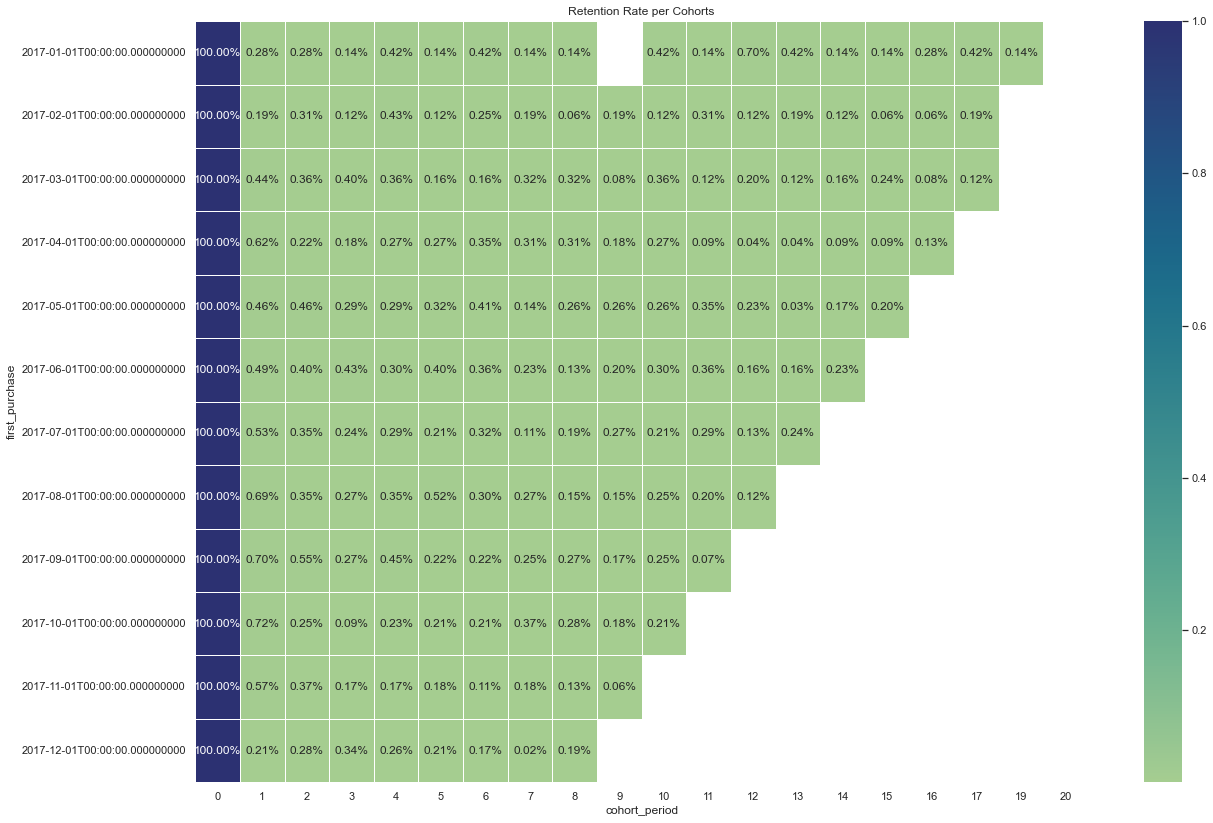

In [325]:
# Рисуем heatmap
plt.figure(figsize=(20, 14))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[3:15, 0:], annot=True, cmap='crest',
            fmt='.2%', linewidths=1, linecolor='white'); 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:

R - время от последней покупки пользователя до текущей даты, 
F - суммарное количество покупок у пользователя за всё время, 
M - сумма покупок за всё время. 

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Шаги по решению задачи:
    
    1. Выберем "завершённые" покупки согласно выбранному критерию с наличием все критической информации в данных, заодно, объединив 2 датасета.
    
    2. Также создадим новый датафрейм, объединив с датафреймом по продукции в заказах.
    
    3. Оставим только необходимые колонки для дальнейших расчётов. Это колонки: order_id, order_purchase_timestamp, customer_unique_id, product_id, price.
    
    4. Поскольку данные приведены за 2016-2018 годы, то расчёт времени от последней покупки пользователей до текущей даты в 2022 году даст "утяжелённые" числа и увеличит время расчётов. Предположим, что текущая дата это последняя дата покупки. При необходимости это допущение можно легко заменить на текущую дату и на RFM анализ наше допущение не влияет.
    
    5. Создаём таблицу RFM согласно выбранным метрикам и переименовываем столбцы.
    
    6. Рассчитываем квантили для последующей разбивки по сегментам.
    
    7. Создаём структуру сегментов (кластеров) с нумераций по каждой метрике.
    
    8. Проводим анализ по разным запросам.

In [327]:
# Step 1.
df_orders_clean=df_orders.merge(df_users, on='customer_id')\
         .query('order_status=="delivered"')\
         .loc[df_orders.order_delivered_customer_date.notnull()]\
         .loc[df_orders.order_approved_at.notnull()]\
         .loc[df_orders.order_delivered_carrier_date.notnull()]

In [328]:
# Step 2.
df_orders_full=df_orders_clean.merge(df_products, how='left', on='order_id')

In [329]:
df_orders_full.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [330]:
# check for NaNs etc.
df_orders_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110173 entries, 0 to 110172
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110173 non-null  object        
 1   customer_id                    110173 non-null  object        
 2   order_status                   110173 non-null  object        
 3   order_purchase_timestamp       110173 non-null  datetime64[ns]
 4   order_approved_at              110173 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110173 non-null  datetime64[ns]
 6   order_delivered_customer_date  110173 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110173 non-null  datetime64[ns]
 8   customer_unique_id             110173 non-null  object        
 9   customer_zip_code_prefix       110173 non-null  int64         
 10  customer_city                  110173 non-null  object        
 11  

In [331]:
# Step 3.
temp=['order_id', 'order_purchase_timestamp', 'customer_unique_id', 'product_id', 'price']
RFM_data=df_orders_full[temp]
RFM_data.head()

,order_id,order_purchase_timestamp,customer_unique_id,product_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,65266b2da20d04dbe00c5c2d3bb7859e,19.90


In [332]:
# Step 4.
NOW = RFM_data.order_purchase_timestamp.max()
NOW

Timestamp('2018-08-29 15:00:37')

In [335]:
# Step 5.
RFM_table = RFM_data.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (NOW - x.max()).days,
                                                        'order_id': lambda x: len(x.unique()),
                                                        'price': lambda x: x.sum()})

In [336]:
RFM_table['order_purchase_timestamp'] = RFM_table['order_purchase_timestamp'].astype(int)

RFM_table.rename(columns={'order_purchase_timestamp': 'recency', 
                         'order_id': 'frequency',
                         'price': 'monetary_value'}, inplace=True)
RFM_table.head()

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
0000f46a3911fa3c0805444483337064,536,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
0004aac84e0df4da2b147fca70cf8255,287,1,180.00


In [337]:
# Step 6.
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,113.0,1.0,47.6500
0.50,218.0,1.0,89.7000
0.75,345.0,1.0,154.6925


In [338]:
# Step 7.
# Преобразуем в словарь для более удобного использования.
quantiles = quantiles.to_dict()

In [339]:
quantiles

{'recency': {0.25: 113.0, 0.5: 218.0, 0.75: 345.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary_value': {0.25: 47.65, 0.5: 89.7, 0.75: 154.6925}}

In [340]:
##  Создаём функции для RFM сегментация
RFM_Segment = RFM_table.copy()
# Аргументы (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [341]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [342]:
# Сегментируем
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [365]:
RFM_Segment.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,1,1,311
0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,4,214


#  STEP 8. ПРОВОДИМ АНАЛИЗ ПО РАЗНЫМ ЗАПРОСАМ.

In [ ]:
Список лучших клиентов (RFMClass = 444):

In [355]:
RFM_Segment.query('RFMClass=="444"').sort_values('monetary_value', ascending=False)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
c8460e4251689ba205045f3ea17884a1,21,4,4080.00,4,4,4,444
7b0eaf68a16e4808e5388c67345033c9,102,2,2238.42,4,4,4,444
906a8a4ec9f3d4c3e64fa6d1c4fe6009,40,2,1835.00,4,4,4,444
0341bbd5c969923a0f801b9e2d10a7b8,91,2,1828.44,4,4,4,444
4facc2e6fbc2bffab2fea92d2b4aa7e4,15,4,1686.90,4,4,4,444
...,...,...,...,...,...,...,...
334d0235ca6f2f09dd55804a26efe952,84,2,157.80,4,4,4,444
7cf08f01ab6a6a1365e1613989a65158,112,2,156.90,4,4,4,444
221d59abddcd719f3ec72c50078b9e31,35,2,156.00,4,4,4,444


Список лояльных клиенты с высоким frequency    

In [356]:
RFM_Segment.query('F_Quartile >= 4').sort_values('monetary_value', ascending=False)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
da122df9eeddfedc1dc1f5349a1a690c,514,2,7388.00,1,4,4,144
c8460e4251689ba205045f3ea17884a1,21,4,4080.00,4,4,4,444
59d66d72939bc9497e19d89c61a96d5f,383,2,3459.00,1,4,4,144
d77aa95864ae5b42160937615628723a,364,2,2400.00,1,4,4,144
7b0eaf68a16e4808e5388c67345033c9,102,2,2238.42,4,4,4,444
...,...,...,...,...,...,...,...
4fe67915d44791a5deab2957c2641048,543,2,20.79,1,4,1,141
728e4a7d0db4845270091ded0923c71f,601,3,20.70,1,4,1,141
031e19fc630c4121f1238716f41675c3,56,2,20.20,4,4,1,441


Какие клиенты давно делали заказы и, возможно, перестанут делать заказы

In [357]:
RFM_Segment.query('R_Quartile<=1').sort_values('monetary_value', ascending=False)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
da122df9eeddfedc1dc1f5349a1a690c,514,2,7388.00,1,4,4,144
dc4802a71eae9be1dd28f5d788ceb526,562,1,6735.00,1,1,4,114
ff4159b92c40ebe40454e3e6a7c35ed6,461,1,6499.00,1,1,4,114
eebb5dda148d3893cdaf5b5ca3040ccb,497,1,4690.00,1,1,4,114
011875f0176909c5cf0b14a9138bb691,528,1,3999.90,1,1,4,114
...,...,...,...,...,...,...,...
4079d39cb3fdea47201540107c1673dc,579,1,3.90,1,1,1,111
2bca5fe01d46ab5cc2bc5aaade88d850,395,1,3.90,1,1,1,111
5a1b7cd1a94f3483b6415f8609db83dc,433,1,3.90,1,1,1,111


Список с низкими показателями, которые, возможно, окончательно, потеряны

In [354]:
RFM_Segment.query('RFMClass=="111"').sort_values('recency',ascending=False)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
2f64e403852e6893ae37485d5fcacdaf,694,1,21.90,1,1,1,111
14359ea0c7a105749c0a56478825b015,694,1,32.49,1,1,1,111
61db744d2f835035a5625b59350c6b63,694,1,36.49,1,1,1,111
f922896769e9517ea3c630f3c8de86d0,694,1,39.99,1,1,1,111
3f4f614c632af7fc7508462a7cb55ac2,694,1,9.90,1,1,1,111
...,...,...,...,...,...,...,...
df28a378659710f7afb9ab93f642db3d,346,1,23.99,1,1,1,111
d401a17e88e606a3ce275061995a2074,346,1,12.90,1,1,1,111
127f8f62505196f9181003fb59ae9e9d,346,1,29.90,1,1,1,111


TOP 10 клиентов, которые принесли больше всего денег и сделали больше всех заказов

In [363]:
RFM_Segment.query('M_Quartile >= 4 & F_Quartile >=4').sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
da122df9eeddfedc1dc1f5349a1a690c,514,2,7388.00,1,4,4,144
c8460e4251689ba205045f3ea17884a1,21,4,4080.00,4,4,4,444
59d66d72939bc9497e19d89c61a96d5f,383,2,3459.00,1,4,4,144
d77aa95864ae5b42160937615628723a,364,2,2400.00,1,4,4,144
7b0eaf68a16e4808e5388c67345033c9,102,2,2238.42,4,4,4,444
86df00dc5fd68f4dd5d5945ca19f3ed6,319,3,2200.00,2,4,4,244
6ddbc64bd04d40f7768ff088d94cbeb8,141,2,2108.00,3,4,4,344
73601b1eec55943e90ce8d61253d5c09,301,2,2009.98,2,4,4,244
1da09dd64e235e7c2f29a4faff33535c,230,3,1980.28,2,4,4,244
